# How much money can we save by cutting public sector wages?
We'll use marginal rates, so that we can protect those who don't earn that much.

This notebook is a mere rough estimation of how much we could potentially save. For a more precise result, we'd need to generate a Probability Density Function using a distribution that makes sense for each group, but that would need a bit more data to be achieved properly.


**Notes:** The source for any magic number you may encounter in this notebook is from ["IPEA's Atlas do Estado Brasileiro"](https://www.ipea.gov.br/atlasestado/), unless otherwise stated.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Filtering and cleaning the dataset

In [2]:
df = pd.read_csv('9532-dados1.csv', sep = ';')

df = df[df['ano'] == 2019]

df.rename(columns={'poder': 'group'}, inplace = True)

df = df.iloc[:, 1:4]

#df['group'] = df['group'].astype('category') # If i cast it as category, the last chart doesn't plot
df['faixa'] = df['faixa'].astype('category')

### Generating wage numbers
For future calculations, I will consider that anyone who earns more than 30k as the following:

**Executivo:** 22 mil

**Legislativo:** 33 mil

**Judiciario:** 41.35 mil

In [3]:
df['meanWage'] = [1.4, (2.5 + 5)/2, (5 + 7.5)/2, (7.5 + 10)/2,
                    (10 + 12.5)/2, (12.5 + 15)/2, (15 + 17.5)/2, (17.5 + 20)/2,
                    (20 + 22.5)/2, (22.5 + 25)/2, (25 + 27.5)/2, (27.5 + 30)/2, 41.35]*3

df.loc[38, 'meanWage'] = 33 #fixing legislativo value
df.loc[12, 'meanWage'] = 22 #fixing executivo value

df['meanWage'] = df['meanWage'] * 1000 #re-scaling values
df

,group,faixa,percentual,meanWage
0,Executivo,"< 2,5 mil",0.464444,1400.0
1,Executivo,"2,5 - 5 mil",0.302453,3750.0
2,Executivo,"5 - 7,5 mil",0.116305,6250.0
3,Executivo,"7,5 - 10 mil",0.049220,8750.0
4,Executivo,"10 - 12,5 mil",0.024077,11250.0
5,Executivo,"12,5 - 15 mil",0.014074,13750.0
6,Executivo,"15 - 17,5 mil",0.008362,16250.0
7,Executivo,"17,5 - 20 mil",0.007497,18750.0
8,Executivo,"20 - 22,5 mil",0.004230,21250.0
9,Executivo,"22,5 - 25 mil",0.003084,23750.0


### Calculating population

A quick google search tells us that there are 10.89 million public sector workers in Brazil.

**Executivo: 10,023 thousand**

**Judiciário: 360.12 thousand**

**Legislativo: 304.29 thousand**

In [4]:
df.loc[df['group'] == 'Executivo', 'population'] = df['percentual'] * 10_023_000
df.loc[df['group'] == 'Judiciario', 'population'] = df['percentual'] * 360_120
df.loc[df['group'] == 'Legislativo', 'population'] = df['percentual'] * 304_290

df['population'] = df['population'].astype('int')

### Calculating marginal rates
We'll test with 2 different *marginal* rates tables to calculate how much money we can potentially save.

#### Soft cut
|Wage|Rate|
|---|---|
|Up to 3750 | 0% |
|3751 ~ 11250 | 4% |
|11251 ~ 21250|	8% |
|Above 21251| 12% |

#### Aggressive cut

|Wage|Rate|
|---|---|
|Up to 3750 | 3% |
|3751 ~ 11250 | 15% |
|11251 ~ 21250|	35% |
|Above 21251| 66% |

In [5]:
def marginalWageCut(df, rates=[0, 0, 0, 0]):  
    # For each row, we're going to add up the portions of the wage that fall into each bracket
    for idx, row in df.iterrows():
        wage = row['meanWage']
        newWage = 0
        
        if wage <= 3750:
            newWage += wage * (1 - rates[0])
        else:
            newWage += 3750 * (1 - rates[0])
        
        if wage > 3750 and wage <= 11250:
            newWage += (wage - 3750) * (1 - rates[1])
        elif wage > 11250:
            newWage += (11250 - 3750) * (1 - rates[1])
            
        if wage > 11250 and wage <= 21250:
            newWage += (wage - 11250) * (1 - rates[2])
        elif wage > 21250:
            newWage += (21250 - 11250) * (1 - rates[2])
            
        if wage > 21250:
            newWage += (wage - 21250) * (1 - rates[3])
        
        df.at[idx, 'newWage'] = newWage
    
    # Calculating how much we're saving | The sum of (Old - New) values
    grouped_Old = (df['population'] * df['meanWage']).groupby(df['group']).sum()
    grouped_New = (df['population'] * df['newWage']).groupby(df['group']).sum()
    
    totalSavings = 0
    
    for group, total in grouped_Old.items():
        groupedTotal = (grouped_Old[group] - grouped_New[group])
        print(f"{group} is saving R$ {groupedTotal:,.0f}")
        totalSavings += groupedTotal
    
    print(f"\nThis is equal to reducing total salary expenditure by {((totalSavings / grouped_Old.sum()) * 100).round(2)}%")
    print(f"Which is also equal to R${totalSavings * 12:,.0f} per year")
    print(f"\nIn terms of GDP (2019), this equals to {((totalSavings / 7_250_000_000_000) * 100).round(2)}%")
    print(f"In terms of Total Government Expenditure (2019), this equals to {((totalSavings / 2_711_000_000_000) * 100).round(2)}%")
    
    return df.copy()

In [6]:
#Soft Cut
softCut = marginalWageCut(df, [.0,.04,.08,.12])

Executivo is saving R$ 674,333,750
Judiciario is saving R$ 182,658,520
Legislativo is saving R$ 55,439,500

This is equal to reducing total salary expenditure by 1.97%
Which is also equal to R$10,949,181,240 per year

In terms of GDP (2019), this equals to 0.01%
In terms of Total Government Expenditure (2019), this equals to 0.03%


In [7]:
#Agressive Cut
aggCut = marginalWageCut(df, [.03,.15,.35,.66])

Executivo is saving R$ 3,533,405,324
Judiciario is saving R$ 824,363,856
Legislativo is saving R$ 265,298,058

This is equal to reducing total salary expenditure by 9.96%
Which is also equal to R$55,476,806,856 per year

In terms of GDP (2019), this equals to 0.06%
In terms of Total Government Expenditure (2019), this equals to 0.17%


### Visualizing the difference

In [8]:
# Combine the dataframes to plot later
aggCut['type'] = 'Aggressive Cut'
softCut['type'] = 'Soft Cut'
df['type'] = 'No Cut (Original Wages)'

combined_df = pd.concat([aggCut, softCut, df], axis=0)

combined_df.reset_index(drop=True, inplace=True) # Without this, next line returns an error
combined_df.loc[combined_df['type'] == 'Original Wages', 'newWage'] = combined_df['meanWage']

In [9]:
#Re-calculate 'faixa' column to the newWage parameter

for idx, row in combined_df.iterrows():
    value = combined_df.at[idx, 'newWage']
    
    if value < 2500:
        combined_df.at[idx, 'faixa'] = '< 2,5 mil'
    elif value < 5000:
        combined_df.at[idx, 'faixa'] = '2,5 - 5 mil'
    elif value < 7500:
        combined_df.at[idx, 'faixa'] = '5 - 7,5 mil'
    elif value < 10000:
        combined_df.at[idx, 'faixa'] = '7,5 - 10 mil'
    elif value < 12500:
        combined_df.at[idx, 'faixa'] = '10 - 12,5 mil'
    elif value < 15000:
        combined_df.at[idx, 'faixa'] = '12,5 - 15 mil'
    elif value < 17500:
        combined_df.at[idx, 'faixa'] = '15 - 17,5 mil'
    elif value < 20000:
        combined_df.at[idx, 'faixa'] = '17,5 - 20 mil'
    elif value < 22500:
        combined_df.at[idx, 'faixa'] = '20 - 22,5 mil'
    elif value < 25000:
        combined_df.at[idx, 'faixa'] = '22,5 - 25 mil'
    elif value < 27500:
        combined_df.at[idx, 'faixa'] = '25 - 27,5 mil'
    elif value < 30000:
        combined_df.at[idx, 'faixa'] = '27,5 - 30 mil'
    else:
        combined_df.at[idx, 'faixa'] = '> 30 mil'

In [10]:
#combined_df.tail(60)

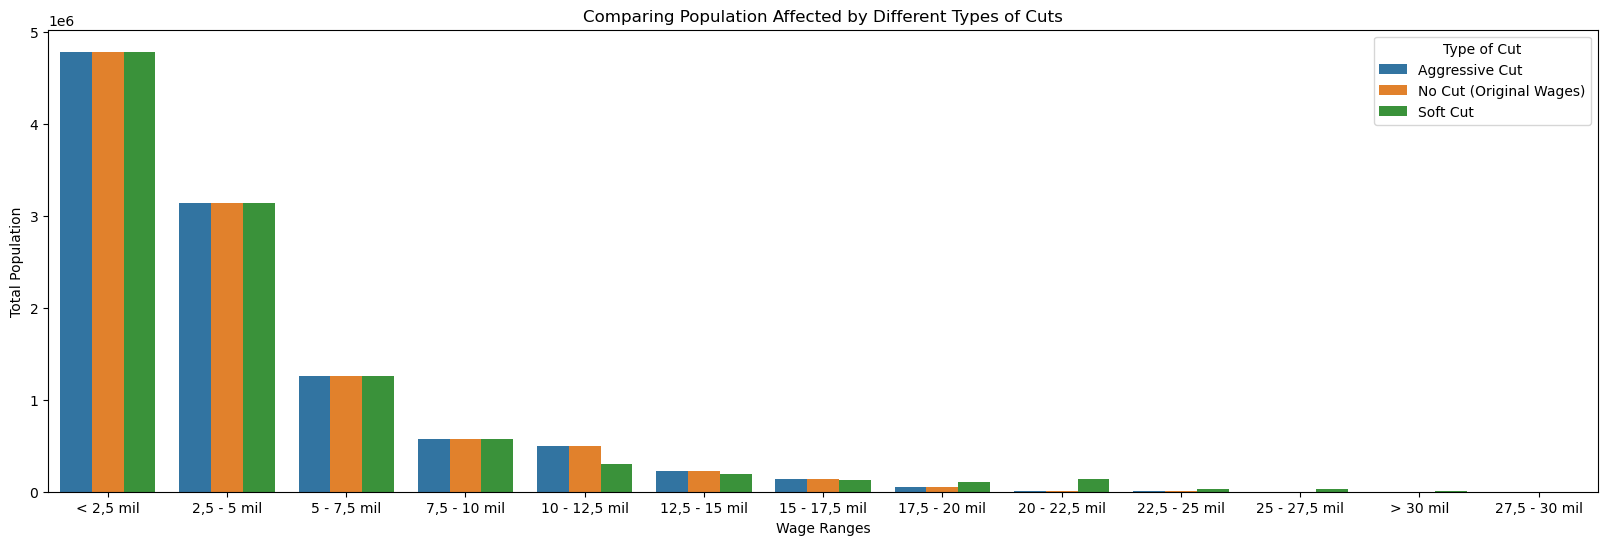

In [11]:
# Assuming your DataFrame is called df
# Aggregate the data by 'faixa' and 'type', summing up the 'population'
aggregated_data = combined_df.groupby(['faixa', 'type']).sum()['population'].reset_index()

# Sort aggregated_data by 'population' in descending order
aggregated_data.sort_values(by='population', ascending=False, inplace=True)

# Create a sorted list of 'faixa' based on 'population'
sorted_faixa = aggregated_data.groupby('faixa')['population'].sum().sort_values(ascending=False).index.tolist()

# Create the barplot
plt.figure(figsize=(20, 6))
sns.barplot(data=aggregated_data, x='faixa', y='population', hue='type', order=sorted_faixa)
plt.title('Comparing Population Affected by Different Types of Cuts')
plt.xlabel('Wage Ranges')
plt.ylabel('Total Population')
plt.legend(title='Type of Cut')
plt.show()

## Next steps:

- We need to fix the final plot. It's plotting total population right now, but we need another plot: how salaries is distributed with each type of cut.

- Perhaps re-do the code for recalculating faixa. This would be too slow for huge datasets.

- Finish documenting this notebook properly

In [12]:
###





















###